# Imports

In [26]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from skimage import io

# Load data and run

In [47]:
im = io.imread('../FIB/Serial-FIB-ASV.tif')
FIB_test = im

Matching slice 1 and slice 2 ...
1070 good matches found
--------------------------------------------------------------------
--------------------------------------------------------------------
Optimisation result: 
Cost:  4562.90625
Message:  `xtol` termination condition is satisfied.
Success:  True
Parameters:  [-5.33053617e+01 -2.63278534e+01  2.25235012e-03  9.99851673e-01]
Matching slice 2 and slice 3 ...
1150 good matches found
--------------------------------------------------------------------
--------------------------------------------------------------------
Optimisation result: 
Cost:  3300.71240234375
Message:  `xtol` termination condition is satisfied.
Success:  True
Parameters:  [-3.88986913e+01 -3.52873650e+01 -1.54084931e-04  1.00004803e+00]
Matching slice 3 and slice 4 ...
1098 good matches found
--------------------------------------------------------------------
--------------------------------------------------------------------
Optimisation result: 
Cost:  2941.5

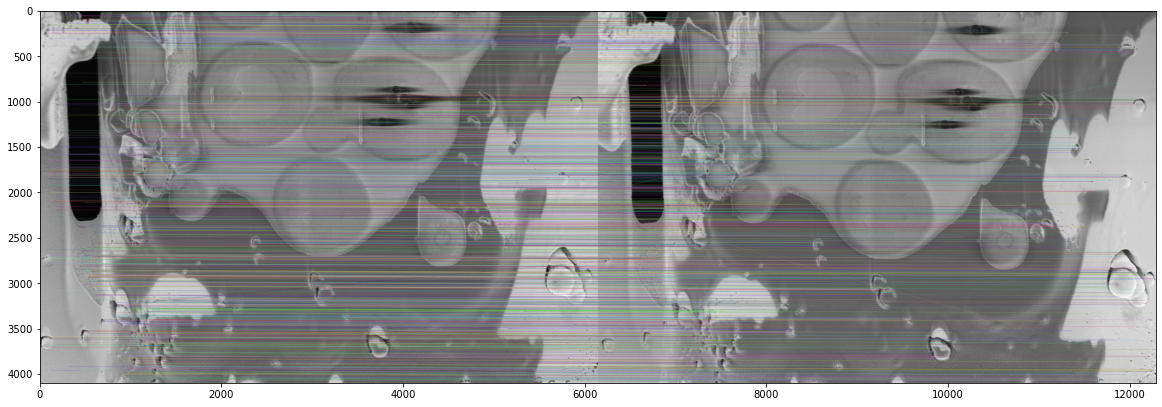

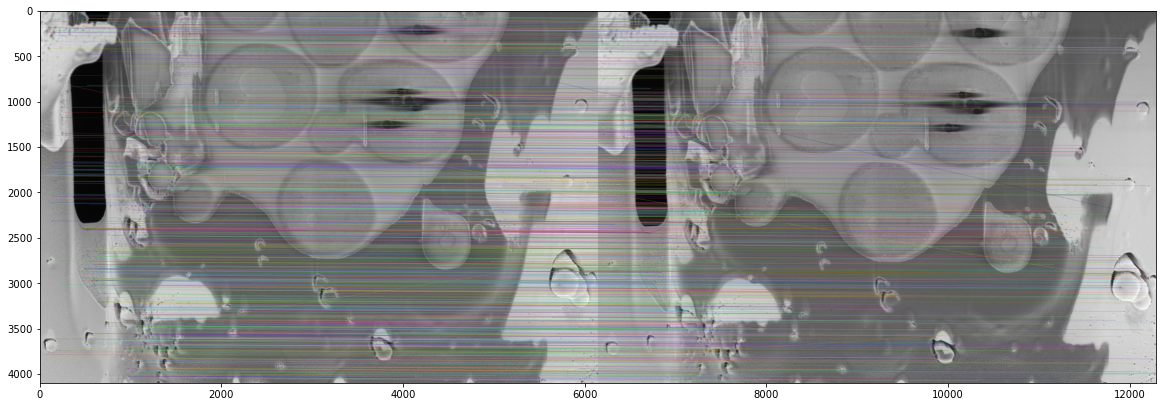

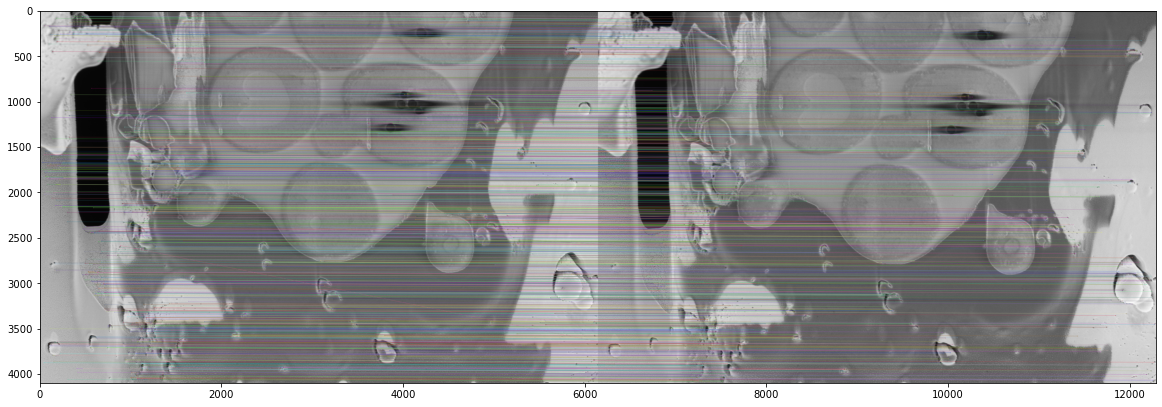

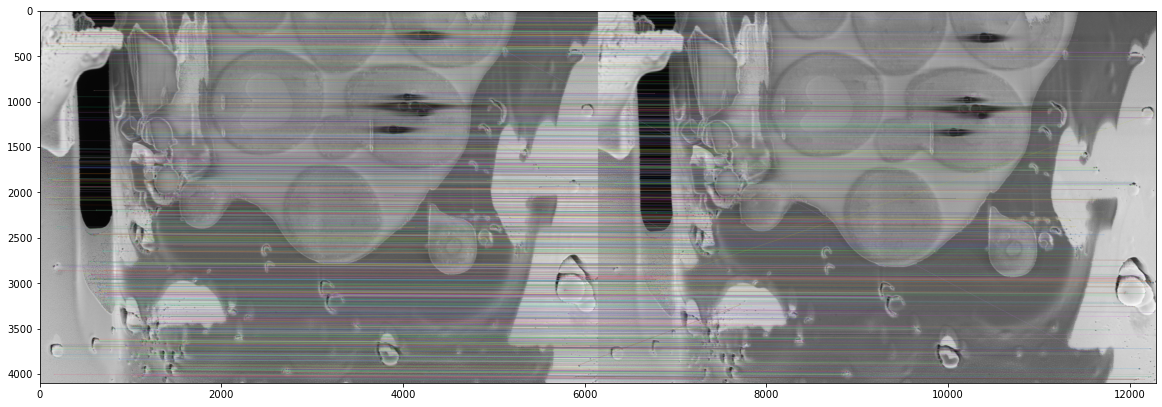

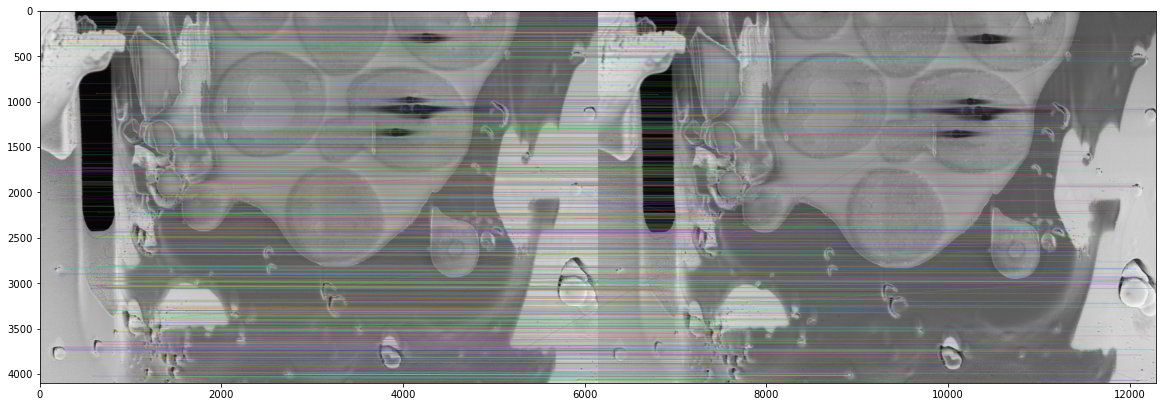

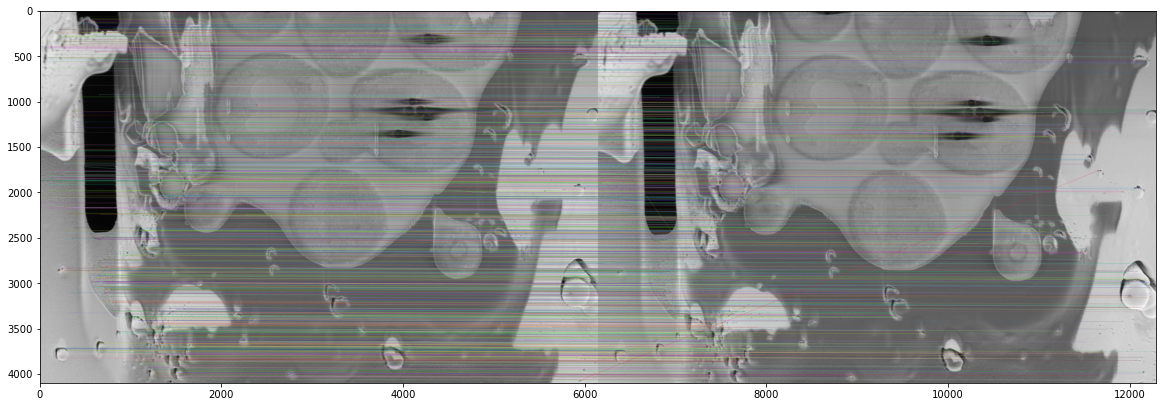

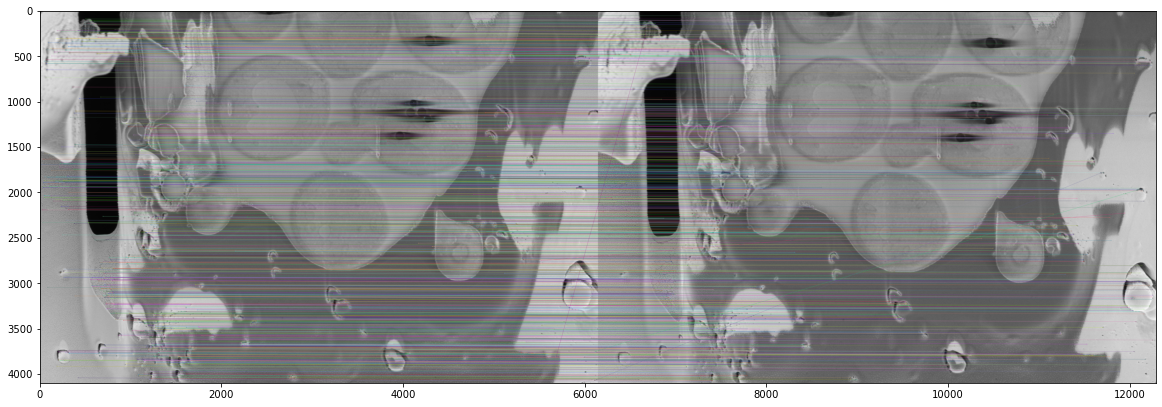

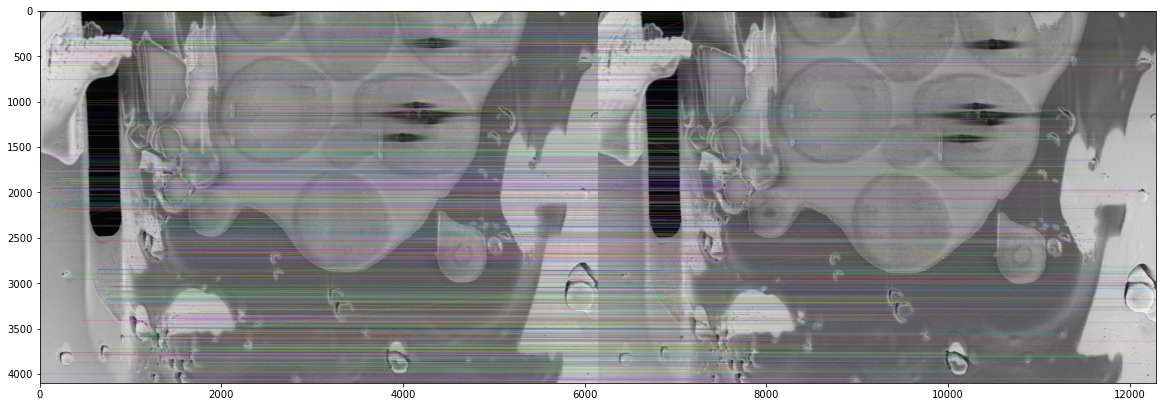

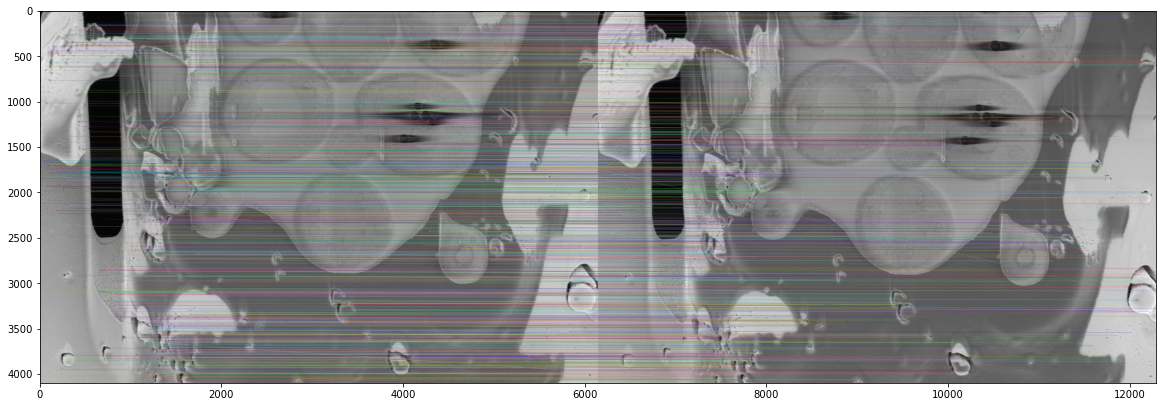

In [17]:
fullimages = align(FIB_test, method_FIB)

# Alignment

## aligment method

In [14]:
method = {'translation':True, 
          'rotation':True, 'shearing_x':False, 'shearing_y':False, 
          'scaling':True, 'stretching_x':False, 'stretching_y':False, 
          'affine':False}

## alignment function

In [24]:
#test canvas size
def align_t(image_sequence, method):
    
    #prepare list of transformation matrice and canvas 
    T0 = np.array([[1, 0, 0], [0, 1, 0]])
    mats = [T0.astype(float)]
    mats_final = []
    affines = [T0[:, :2].astype(float)]
    translates = [T0[:, 2].astype(float)]
    canvas = []
    output = []
    
    #match each image with the previous image as reference
    for i in range(len(image_sequence) - 1):
        ref = image_sequence[i]
        new = image_sequence[i + 1]    
        print(f'Matching slice {i + 1} and slice {i + 2} ...')    
        
        #feature matching
        matches = featureMatchingDS(ref, new)
        
        x_ref = matches[0][:, 0, 0]
        y_ref = matches[0][:, 0, 1]
        coor_ref = [x_ref, y_ref]

        x_new = matches[1][:, 0, 0]
        y_new = matches[1][:, 0, 1]
        coor_new = [x_new, y_new]
        
        
        #find optimal transformation
        t0, bounds = findInitialandBounds(method)
        res = least_squares(residual(coor_ref, coor_new, method), t0, bounds=bounds)
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('Optimisation result: ')
        print('Cost: ', res.cost)
        print('Message: ', res.message)
        print('Success: ', res.success)
        print('Parameters: ', res.x)
        
        T, affine, translate = findMatrix(method, res.x)
        mats.append(T)
        affines.append(affine)
        translates.append(translate)
        
        
    for i in range(len(image_sequence)):
        print(f'for image {i + 1}:')
        print('matrix: \n', mats[i])
        
        if i > 1:
            m_out = np.array([[1, 0], [0, 1]])
            t_out = np.array([0, 0]).astype(float)
            
            for j in range(i):
                m_out = np.matmul(m_out, affines[j + 1])
                t_out += translates[j + 1]
                print(translates[j + 1])
            
            #t_out += translation_distT
            transformation = np.column_stack((m_out,t_out))
            print('transformation matrix: \n', transformation)
        
        else:
            transformation = mats[i]
            #print('transformation matrix: \n', transformation)
            
        mats_final.append(transformation)
        
        
    for T in mats_final:
        #calculate image size so that all images are completely on the canvas
        width_new, length_new = new.shape
        width_ref, length_ref = ref.shape
        width = max(width_new, width_ref)
        length = max(length_new, length_ref)
        
        before_points = np.float32([[0, 0], [0, width], [length, width], [length, 0]]).reshape(-1, 1, 2)
        after_points = cv.transform(before_points, T)
        
        list_of_points = np.float32([[0, 0], [0, width], [length, width], [length, 0]]).reshape(-1, 1, 2)
        list_of_points = np.append(list_of_points, after_points, axis=0)
        
        [x_minT, y_minT] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
        [x_maxT, y_maxT] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
        
        canvas.append([x_minT, y_minT, x_maxT, y_maxT])
        
        
    x_min = min(canvas[i][0] for i in range(len(canvas)))
    y_min = min(canvas[i][1] for i in range(len(canvas)))
    x_max = max(canvas[i][2] for i in range(len(canvas)))    
    y_max = max(canvas[i][3] for i in range(len(canvas)))
    
    translation_distT = [-x_min, -y_min]
    print(translation_distT)
    
        
    for i in range(len(image_sequence)):
        mats_final[i][:, 2] += translation_distT
        image_t = cv.warpAffine(image_sequence[i], mats_final[i], (x_max - x_min, y_max - y_min))
        plt.imsave(f'../sequence/{i + 1}.jpg', image_t, cmap='gray')
        output.append(image_t)

    return output

# Auxiliary functions

## Downsampling

In [6]:
def downSample(img, level):
    G = img.copy()
    gp = [G]
    for i in range(level):
        G = cv.pyrDown(G)
        gp.append(np.float32(G))

    #use images dowmsampled 4 times
    img_ds = gp[level]

    #SIFT only takes 8 bit images
    img_8bit = cv.normalize(img_ds, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    
    return img_8bit

## Feature matching with filter

In [87]:
def featureMatchingDS(img1, img2):
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)

    good = []
    good_no_list = []
    for m, n in matches:
        if m.distance < 0.65*n.distance:
            good.append([m])
            good_no_list.append(m)

    reference_pts = np.float32([kp1[m.queryIdx].pt for m in good_no_list]).reshape(-1, 1, 2)     
    new_pts = np.float32([kp2[m.trainIdx].pt for m in good_no_list]).reshape(-1, 1, 2)

    x_ref, y_ref = reference_pts[:, 0, 0], reference_pts[:, 0, 1]
    x_new, y_new = new_pts[:, 0, 0], new_pts[:, 0, 1]

    slope = np.arctan2((y_new - y_ref), (x_new - x_ref))
    dist = np.sqrt((y_new - y_ref) ** 2 + (x_new - x_ref) ** 2)
    
    points_ref = [img1[x, y] for x, y in zip(y_ref.astype(int), x_ref.astype(int))]
    points_new = [img2[x, y] for x, y in zip(y_new.astype(int), x_new.astype(int))]
    
    #slope_select = np.logical_and(slope > np.median(slope) - 0.08, slope < np.median(slope) + 0.08)
    dist_select = np.logical_and(dist > np.median(dist) * 0.95, dist < np.median(dist) * 1.05)
    points_select = np.logical_and(np.array(points_ref) > 1, np.array(points_new) > 1)
    
    select = dist_select * points_select

    matched_filtered = np.array(good)[select]
    reference_pts = reference_pts[select]    
    new_pts = new_pts[select]
    
    print(f'{len(matched_filtered)} good matches found')

    # cv.drawMatchesKnn expects list of lists as matches.
    img_match_gauss = cv.drawMatchesKnn(img1,kp1,img2,kp2,matched_filtered,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize = (20,20))
    plt.imshow(img_match_gauss)
    
    return reference_pts, new_pts

## Transformation 

In [8]:
def transform(method, param, points):
    x0 = points[0]
    y0 = points[1]
    
    #rotation or shearing
    if method['rotation'] == True:
        x1 = np.cos(param[2]) * x0 - np.sin(param[2]) * y0
        y1 = np.sin(param[2]) * x0 + np.cos(param[2]) * y0
    
    elif method['shearing_x'] == True:
        x1 = x0 + param[2] * y0
        y1 = y0
        
    elif method['shearing_y'] == True:
        x1 = x0
        y1 = param[2] * x0 + y0
    
    else:
        x1 = x0
        y1 = y0
    
    #scaling or stretching
    if method['scaling'] == True:
        x1 = x1 * param[3]
        y1 = y1 * param[3]
        
    elif method['stretching_x'] == True and method['stretching_y'] == False:
        x1 = x1 * param[3]
        y1 = y1
    
    elif method['stretching_y'] == True and method['stretching_x'] == False:
        x1 = x1
        y1 = y1 * param[3]
        
    elif method['stretching_x'] == True and method['stretching_y'] == True:
        x1 = x1 * param[3]
        y1 = y1 * param[4]
        
        
    #affine 
    if method['affine'] == True:
        x1 = param[2] * x0 + param[3] * y0
        y1 = param[4] * x0 + param[5] * y0
        
        
    #translation    
    if method['translation'] == True:
        x1 += param[0]
        y1 += param[1]
        
    return x1, y1

In [9]:
def findMatrix(method, params):
    if method['affine'] == True:
        T = np.array([[params[2], params[3], params[0]], [params[4], params[5], params[1]]])
        
    elif method['scaling'] == True:
        if method['rotation'] == True:
            T = np.array([[params[3] * np.cos(params[2]), -params[3] * np.sin(params[2]), params[0]], 
                          [params[3] * np.sin(params[2]), params[3] * np.cos(params[2]), params[1]]])
        elif method['shearing_x'] == True:
            T = np.array([[params[3], params[3] * params[2], params[0]], [0, params[3], params[1]]])
        elif method['shearing_y'] == True:
            T = np.array([[params[3], 0, params[0]], [params[3] * params[2], params[3], params[1]]])
        else:
            T = np.array([[params[2], 0, params[0]], [0, params[2], params[1]]])
            
    elif method['stretching_x'] == True:
        if method['rotation'] == True:
            T = np.array([[params[3] * np.cos(params[2]), -np.sin(params[2]), params[0]], 
                          [params[3] * np.sin(params[2]), np.cos(params[2]), params[1]]])
        elif method['shearing_x'] == True:
            T = np.array([[params[3], params[2], params[0]], [0, 1, params[1]]])
        elif method['shearing_y'] == True:
            T = np.array([[params[3], 0, params[0]], [params[3] * params[2], 1, params[1]]])
        else:
            T = np.array([[params[2], 0, params[0]], [0, 1, params[1]]])
            
    elif method['stretching_y'] == True:
        if method['rotation'] == True:
            T = np.array([[np.cos(params[2]), -params[3] * np.sin(params[2]), params[0]], 
                          [np.sin(params[2]), params[3] * np.cos(params[2]), params[1]]])
        elif method['shearing_x'] == True:
            T = np.array([[1, params[3] * params[2], params[0]], [0, params[3], params[1]]])
        elif method['shearing_y'] == True:
            T = np.array([[1, 0, params[0]], [params[2], params[3], params[1]]])
        else:
            T = np.array([[1, 0, params[0]], [0, params[2], params[1]]])
            
    else:
        if method['rotation'] == True:
            T = np.array([[np.cos(params[2]), -np.sin(params[2]), params[0]], [np.sin(params[2]), np.cos(params[2]), params[1]]])
        elif method['shearing_x'] == True:
            T = np.array([[1, params[2], params[0]], [0, 1, params[1]]])
        elif method['shearing_y'] == True:
            T = np.array([[1, 0, params[0]], [params[2], 1, params[1]]])
        else:
            T = np.array([[1, 0, params[0]], [0, 1, params[1]]])
            
    affine = T[:, :2]
    translate = T[:, 2]

    return T, affine, translate

## Least Square

### Find residual

In [10]:
def residual(ref, new, method):
    def r(t):
        rx = transform(method, t, new)[0] - ref[0]
        ry = transform(method, t, new)[1] - ref[1]
        return np.append(rx, ry)
    return r

### Find initial values and bounds

In [53]:
def findInitialandBounds(method, margin_t=500, margin_a=0.01):
    if method['affine'] == True:
        t0 = np.array([0, 0, 1, 0, 0, 1])
        bounds = ([-margin_t, -margin_t, 1 - margin_a, -margin_a, -margin_a, 1 - margin_a]
                  , [margin_t, margin_t, 1 + margin_a, margin_a, margin_a, 1 + margin_a])
    
    elif method['scaling'] == True or method['stretching_x'] == True or method['stretching_y'] == True:
        if method['rotation'] == True or method['shearing_x'] == True or method['shearing_y'] == True:
            t0 = np.array([0, 0, 0, 1])
            bounds = ([-margin_t, -margin_t, -margin_a, 1 - margin_a], [margin_t, margin_t, margin_a, 1 + margin_a])
        else:
            t0 = np.array([0, 0, 1])
            bounds = ([-margin_t, -margin_t, 1 - margin_a], [margin_t, margin_t, 1 + margin_a])
    
    else:
        if method['rotation'] == True or method['shearing_x'] == True or method['shearing_y'] == True:
            t0 = np.zeros(3)
            bounds = ([-margin_t, -margin_t, -margin_a], [margin_t, margin_t, margin_a])
        else:
            t0 = np.zeros(2)
            bounds = ([-margin_t, -margin_t], [margin_t, margin_t])
            
    return t0, bounds